In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import pandas as pd
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


Text(0,0.5,'Quantity sold')

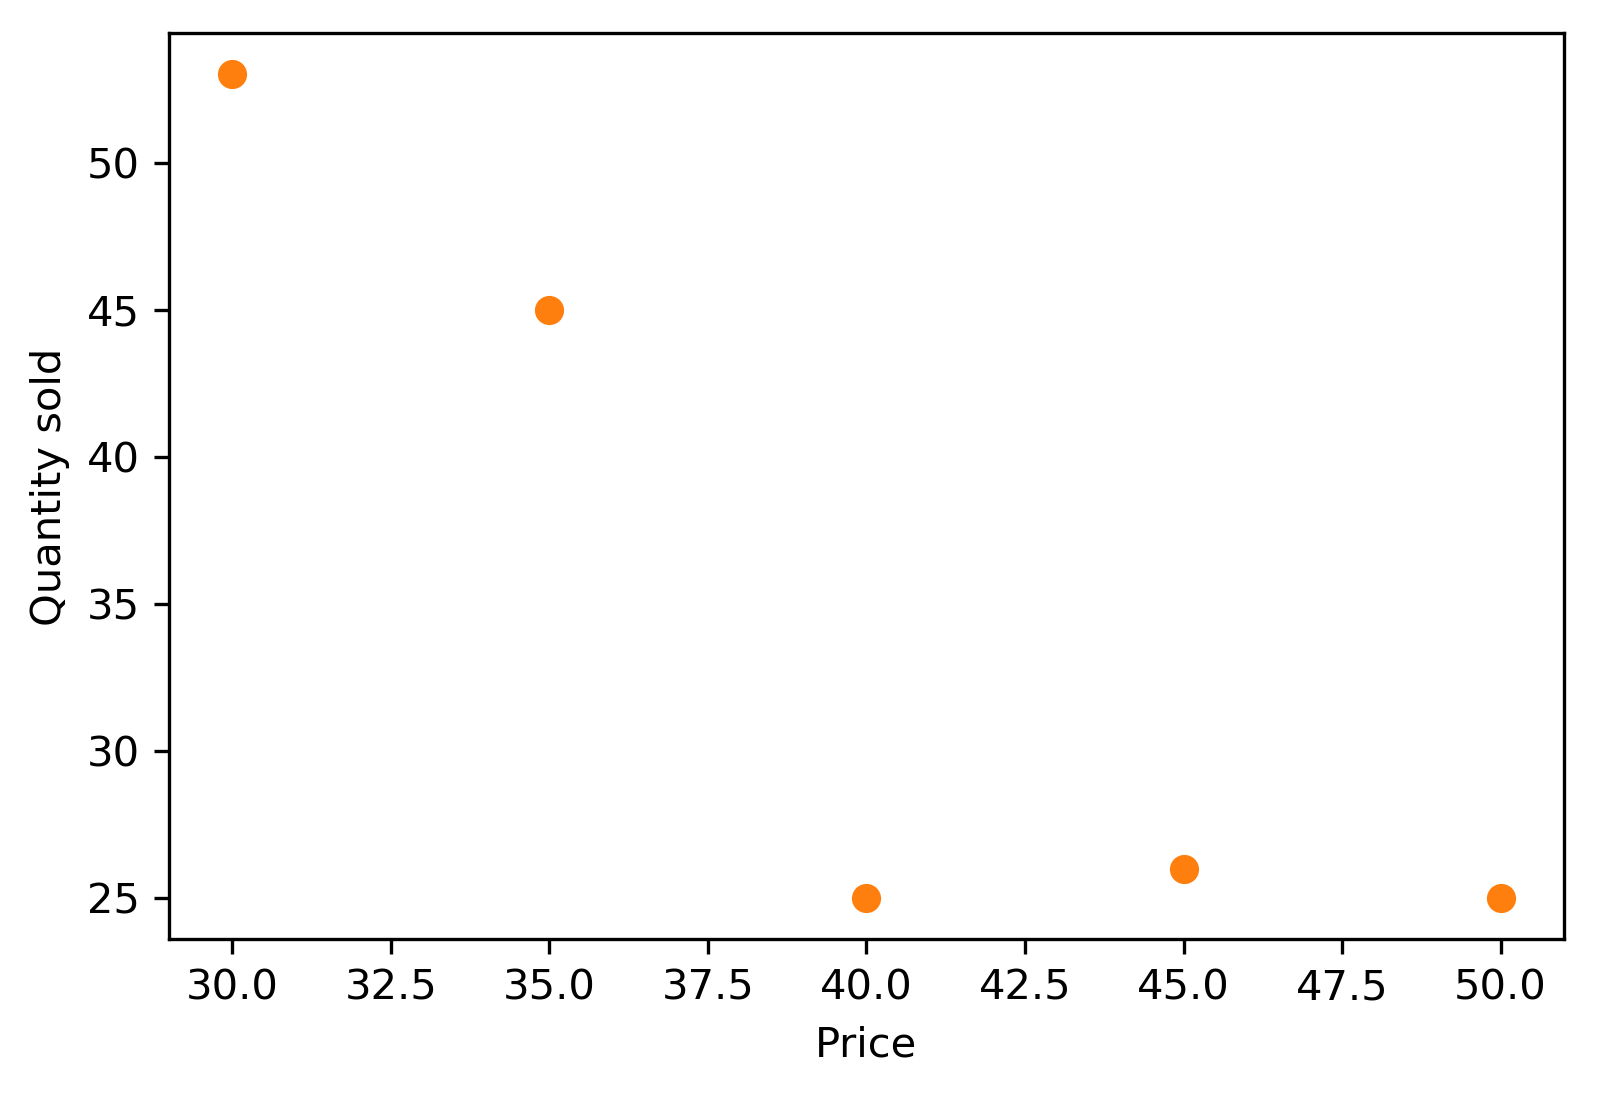

In [2]:
np.random.seed(42)
a = 50000
k = 20
c = -2
p  = np.linspace(25,55)
p0 = np.linspace(30,50,5)
eq = a * p**c
q0 = np.random.poisson(a * p0**c)
π = eq * (p - k)

# np.log(prices-k) + np.log(a) + c*np.log(prices)

#plt.plot(p,π);
plt.plot(p0,q0,'o',c='C1');
plt.xlabel('Price')
plt.ylabel('Quantity sold')

In [3]:
import pymc3 as pm

In [4]:
with pm.Model() as m:
    loga = pm.Cauchy('loga',0,5)
    c = pm.Cauchy('c',0,5,testval=-5)
    μ0 = pm.Deterministic('μ0',np.exp(loga+c*np.log(p0)))
    qval = pm.Poisson('q',μ0,observed=q0)

In [5]:
with m:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c, loga]
100%|██████████| 1000/1000 [00:03<00:00, 297.87it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '5035' (I am process '5037')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/chad/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '5035' (I am process '5038')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/chad/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.3-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '5037' (I am process '5038')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/chad/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.6.3-64/lock_dir
Th

In [6]:
pm.summary(trace)

mean        sd  mc_error    hpd_2.5   hpd_97.5   n_eff      Rhat
loga    9.316811  1.425638  0.057831   6.369962  12.012491   509.0  1.002394
c      -1.583000  0.392663  0.015906  -2.325262  -0.780734   511.0  1.002582
μ0__0  51.381186  5.854107  0.210058  40.090481  63.167145   660.0  1.001308
μ0__1  40.116357  3.145658  0.089207  34.211567  46.619768  1072.0  1.001705
μ0__2  32.470436  2.517684  0.066081  27.487021  37.516656  1311.0  1.004129
μ0__3  27.006763  2.758972  0.090132  21.963611  32.720509   819.0  1.005069
μ0__4  22.944818  3.087252  0.112360  17.327258  29.193307   660.0  1.005001

Text(0,0.5,'$\\log a$')

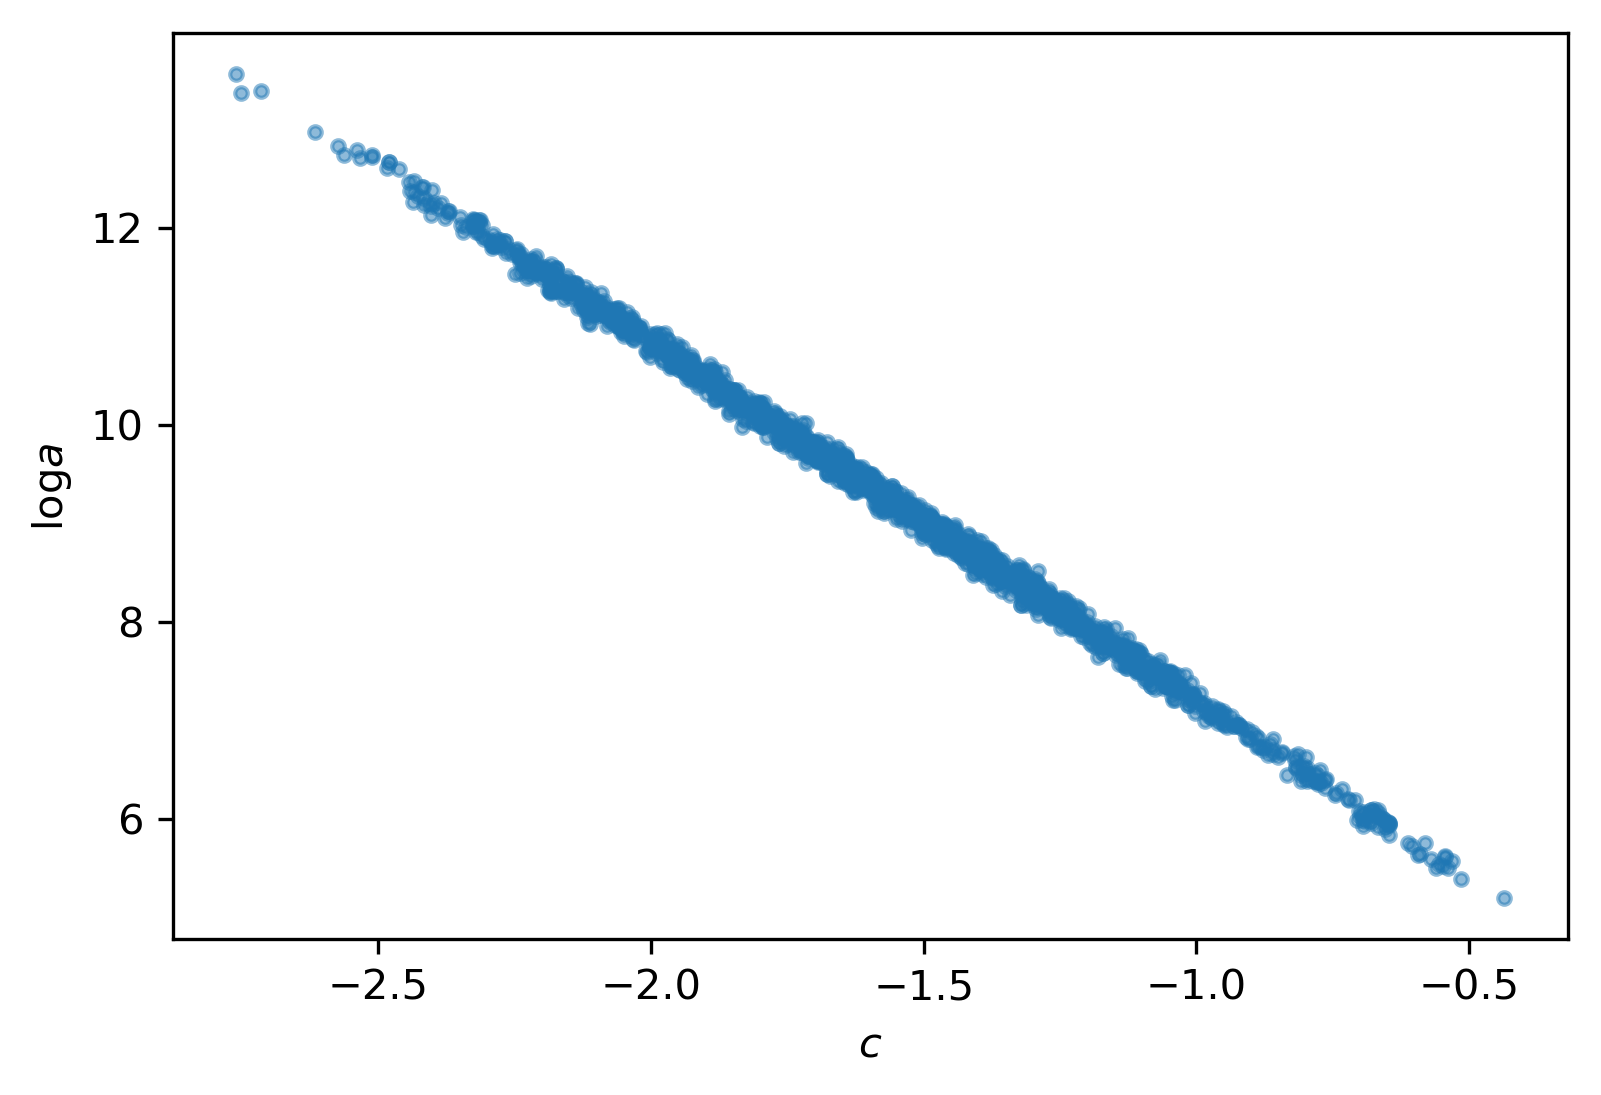

In [7]:
plt.plot(trace['c'],trace['loga'],'.',alpha=0.5)
plt.xlabel('$c$')
plt.ylabel('$\log a$')

In [8]:
with pm.Model() as m2:
    α = pm.Cauchy('α',0,5)
    β = pm.Cauchy('β',0,5)
    logμ0 = α + β * (np.log(p0) - np.log(p0).mean())
    μ0 = pm.Deterministic('μ0',np.exp(logμ0))
    qval = pm.Poisson('q0',μ0,observed=q0)

In [9]:
with m2:
    t = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
100%|██████████| 1000/1000 [00:00<00:00, 1445.02it/s]


In [10]:
pm.summary(t)

mean        sd  mc_error    hpd_2.5   hpd_97.5   n_eff      Rhat
α       3.493167  0.079660  0.001887   3.335115   3.639725  1625.0  1.001538
β      -1.728816  0.410870  0.009551  -2.529837  -0.937256  1657.0  0.999043
μ0__0  52.965520  6.208047  0.147731  41.559279  65.272974  1516.0  1.000229
μ0__1  40.427483  3.253443  0.077845  34.482878  46.978902  1346.0  1.001434
μ0__2  32.096151  2.613836  0.061121  26.666848  36.776567  1673.0  1.001285
μ0__3  26.249544  2.830749  0.065044  20.491854  31.379136  1780.0  1.000282
μ0__4  21.970928  3.102543  0.071003  16.201299  28.079443  1758.0  0.999751

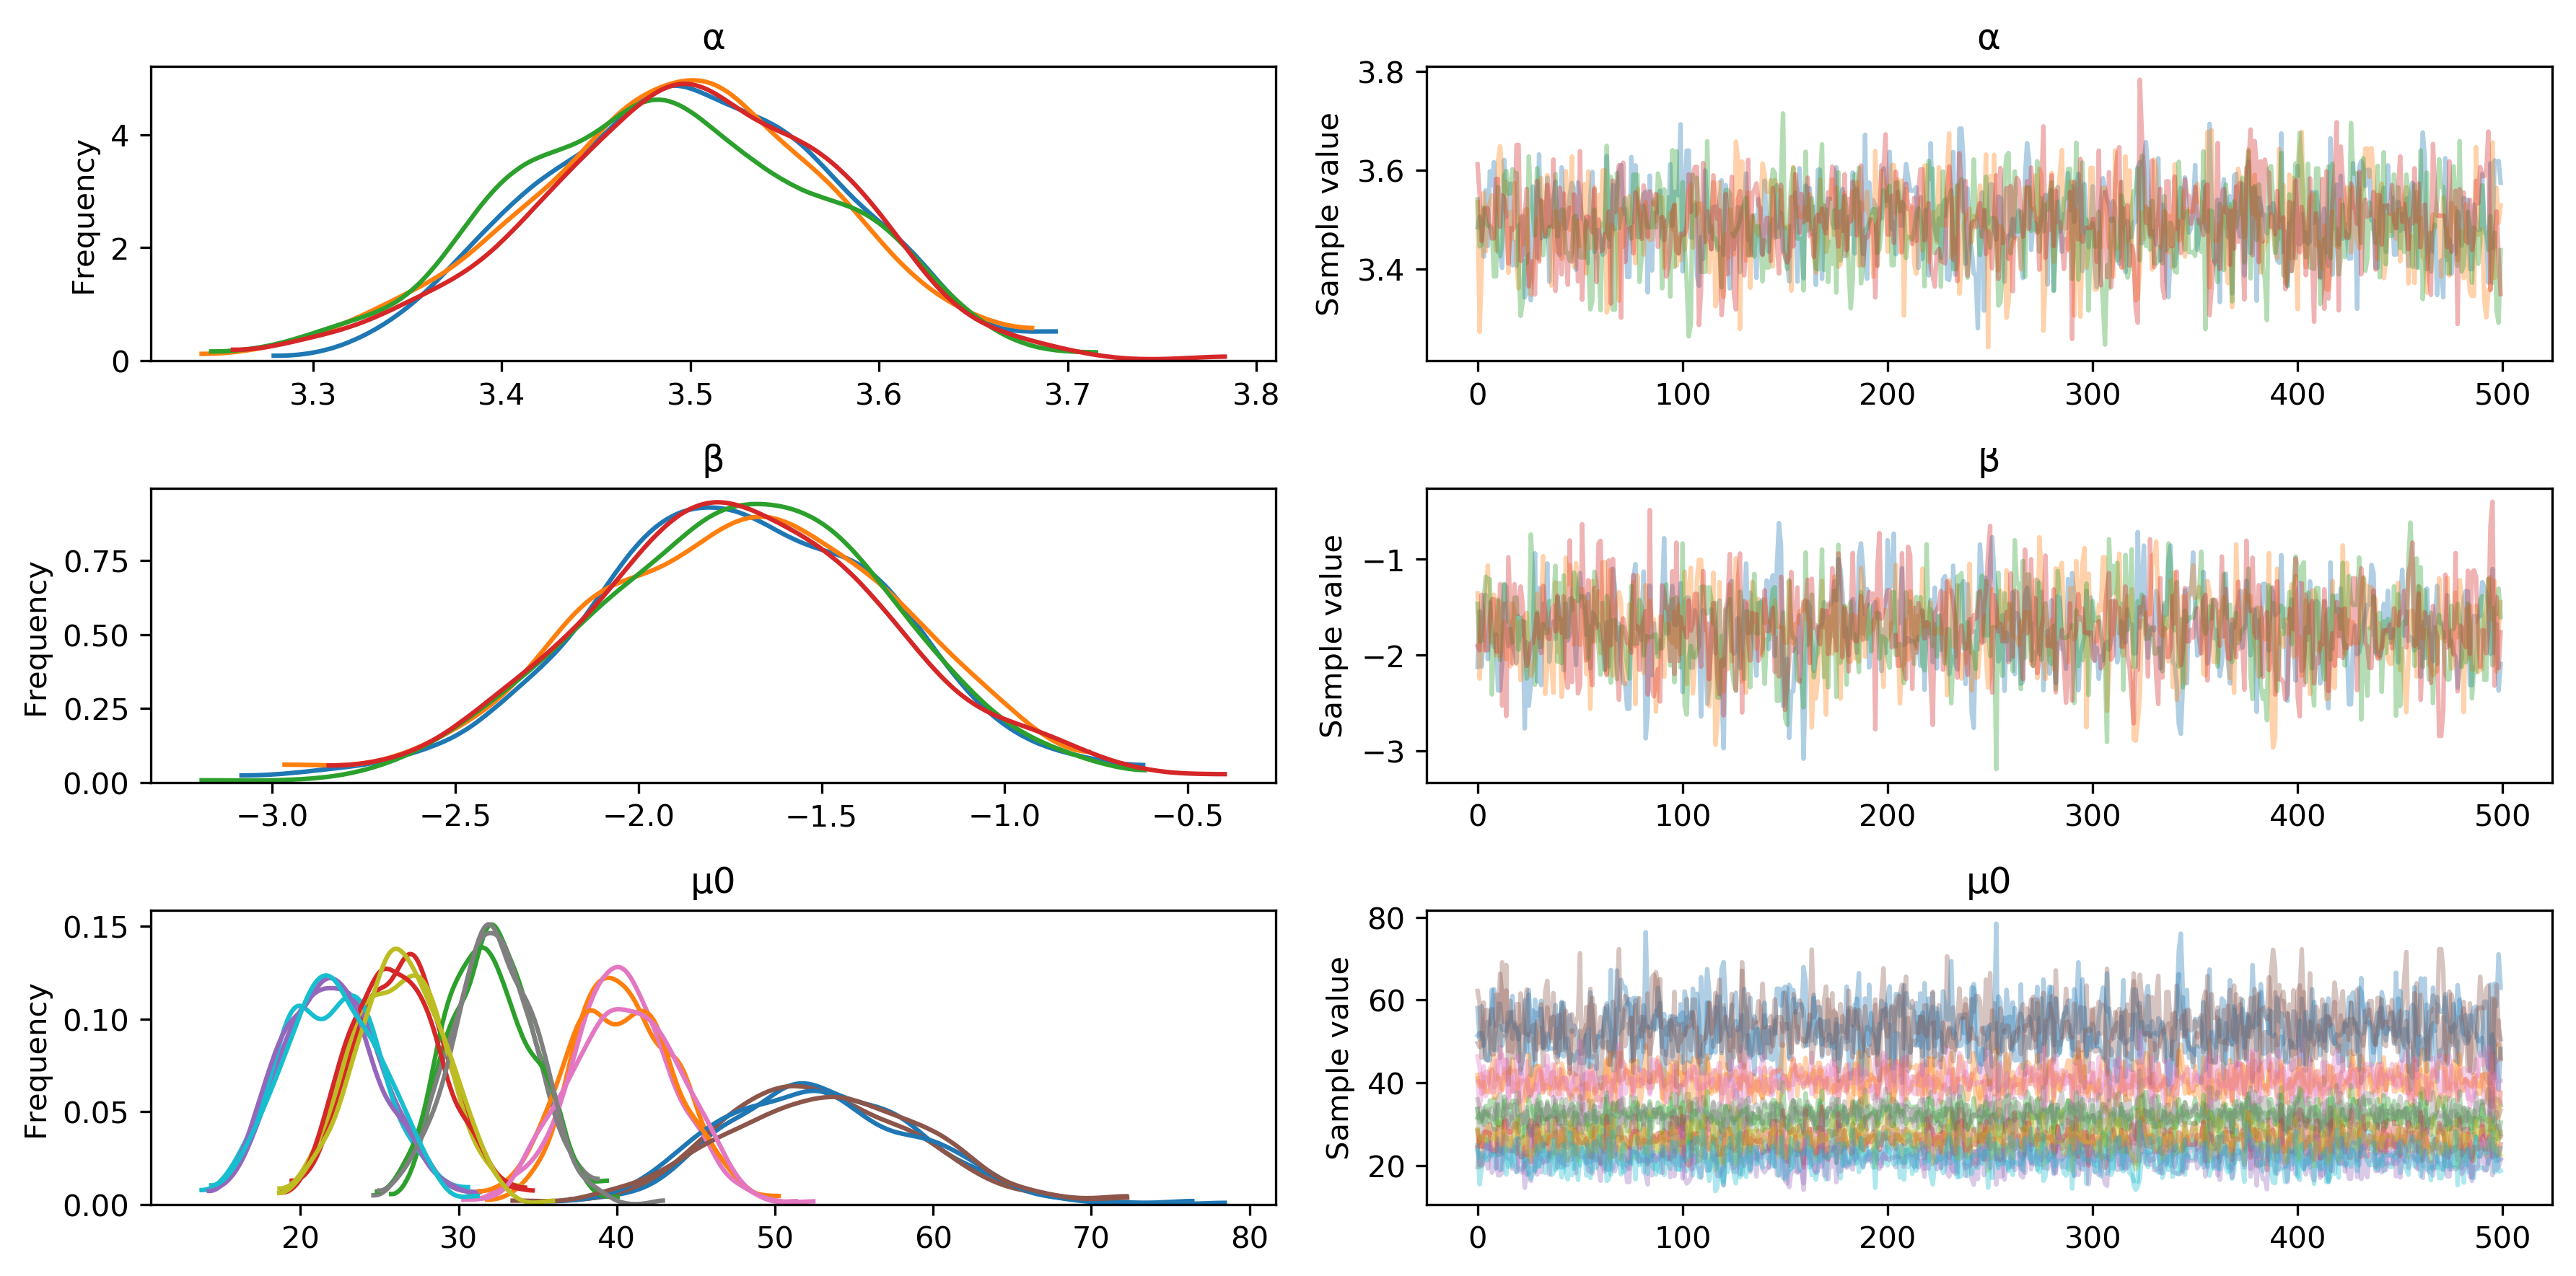

In [11]:
pm.traceplot(t);

Text(0,0.5,'$\\beta$')

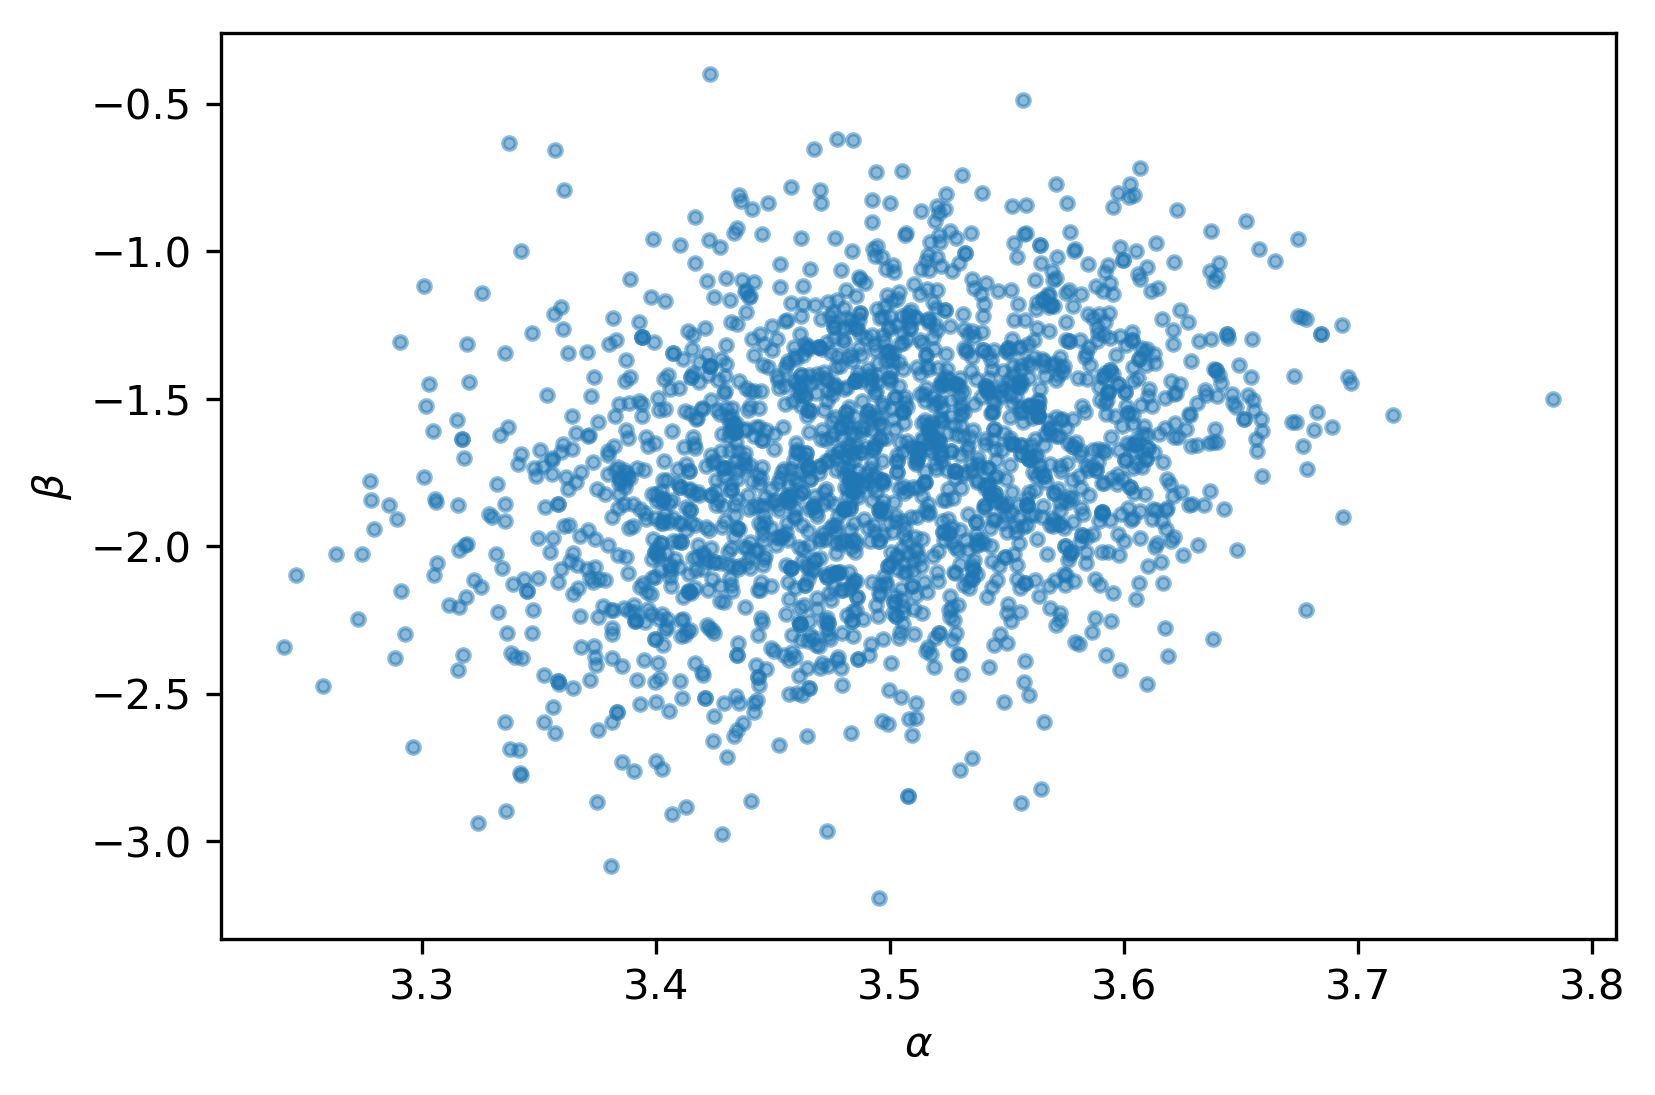

In [12]:
plt.plot(t['α'],t['β'],'.',alpha=0.5);
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')

In [13]:
t.stat_names

{'depth',
 'diverging',
 'energy',
 'energy_error',
 'max_energy_error',
 'mean_tree_accept',
 'step_size',
 'step_size_bar',
 'tree_size',
 'tune'}

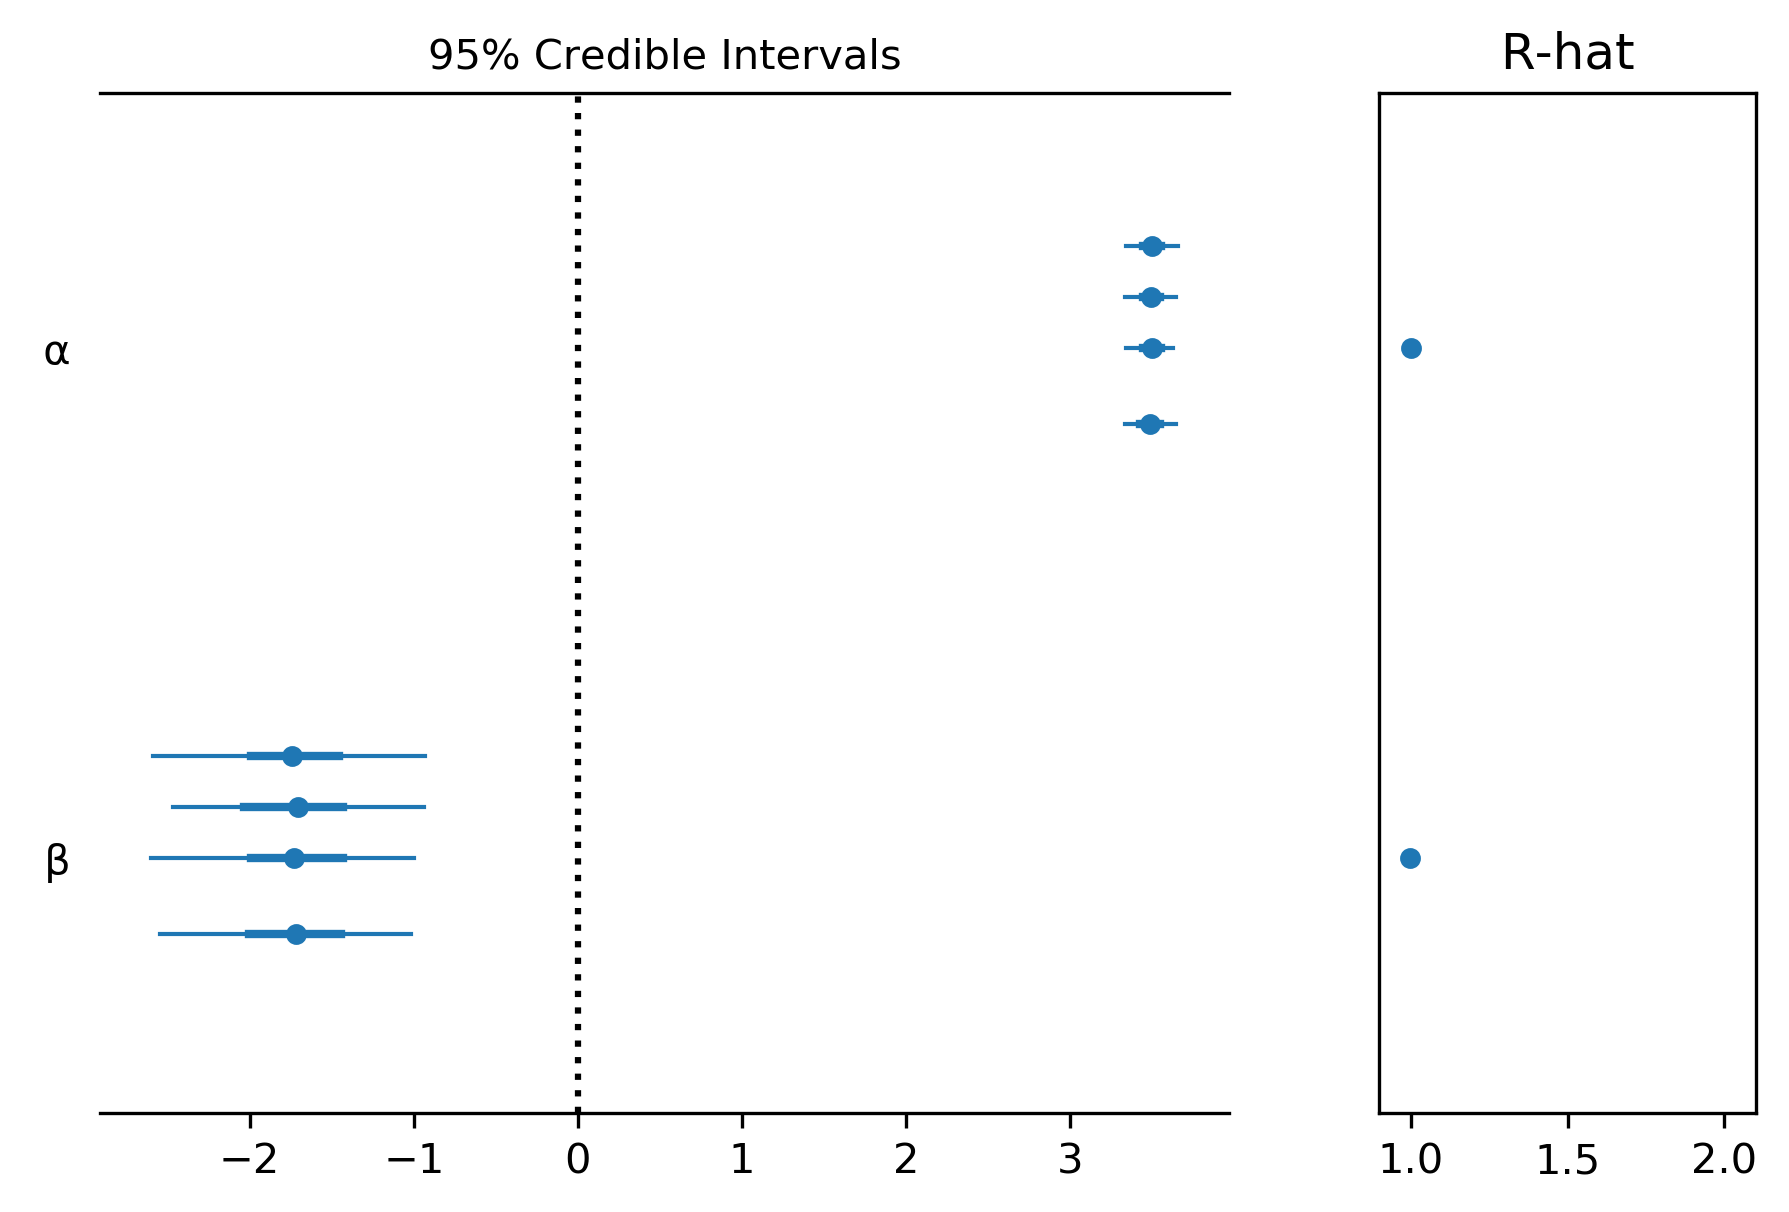

In [14]:
pm.forestplot(t,varnames=['α','β'])

In [15]:
μ = np.exp(t.α + t.β * (np.log(p).reshape(-1,1) - np.log(p0).mean()))

Text(0,0.5,'Quantity')

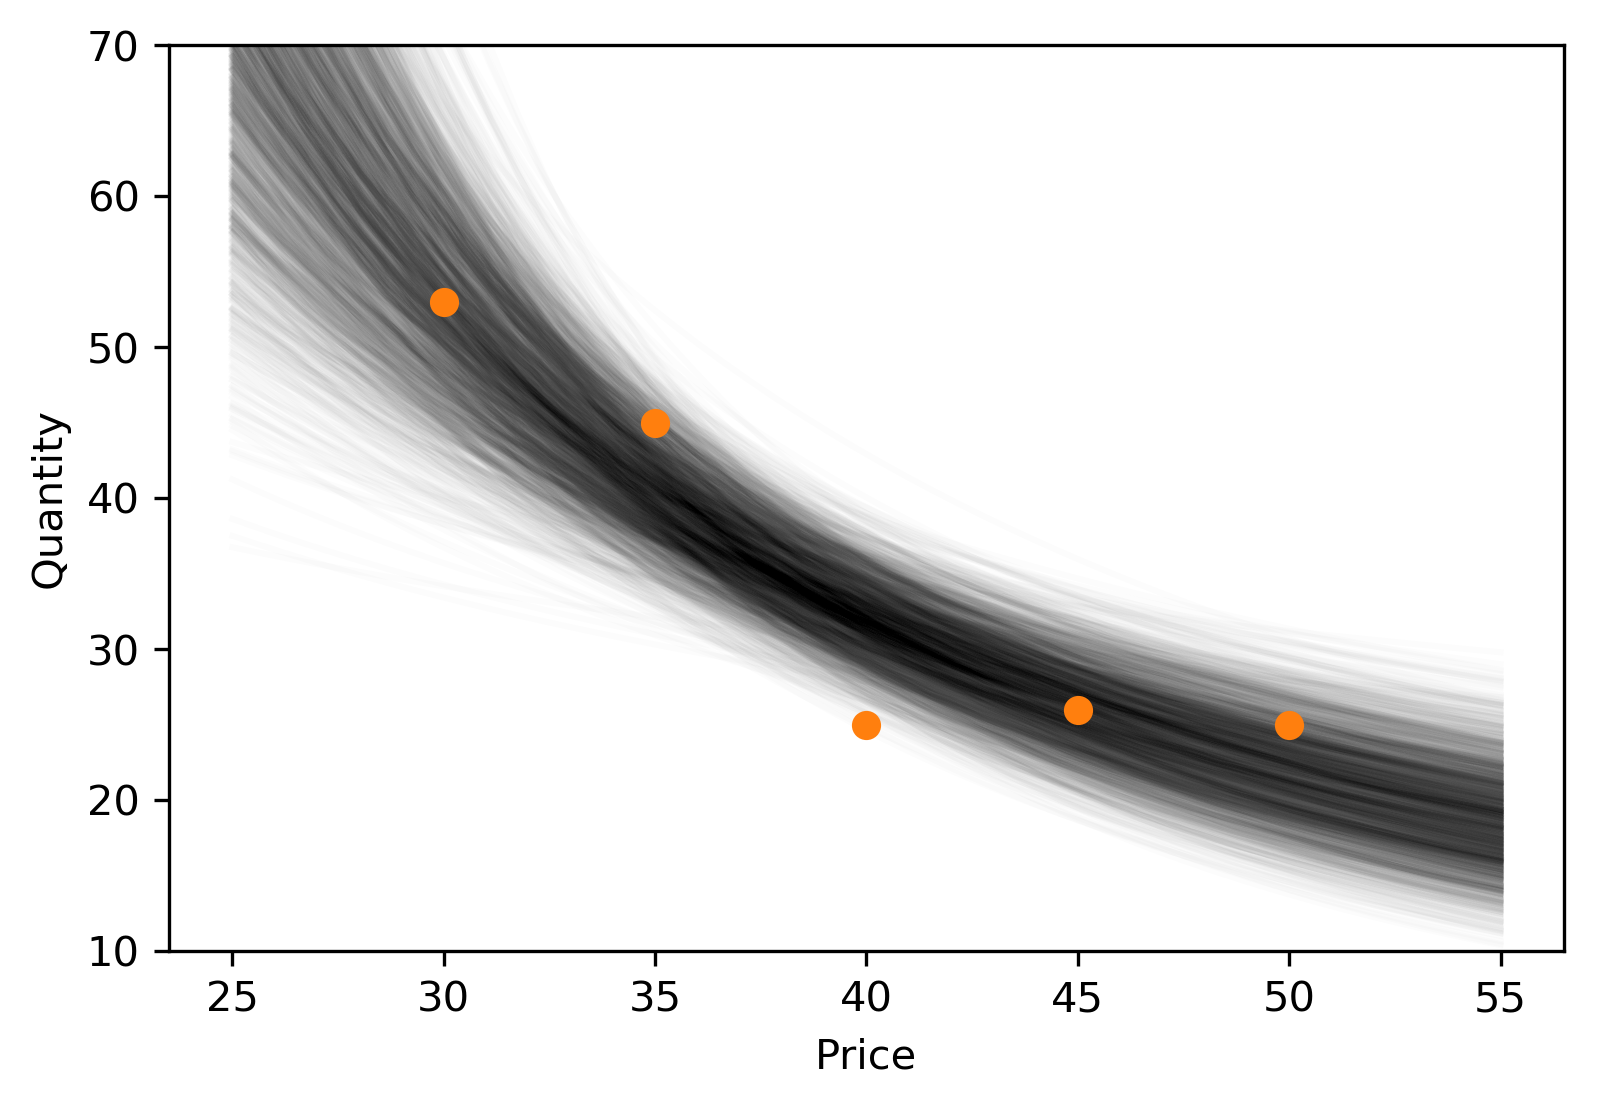

In [16]:
# Checking model fit

plt.plot(p,μ,c='k',alpha=0.01);
plt.plot(p0,q0,'o',c='C1');
#plt.plot(p,eq)
plt.ylim(10,70)
plt.xlabel('Price')
plt.ylabel('Quantity')

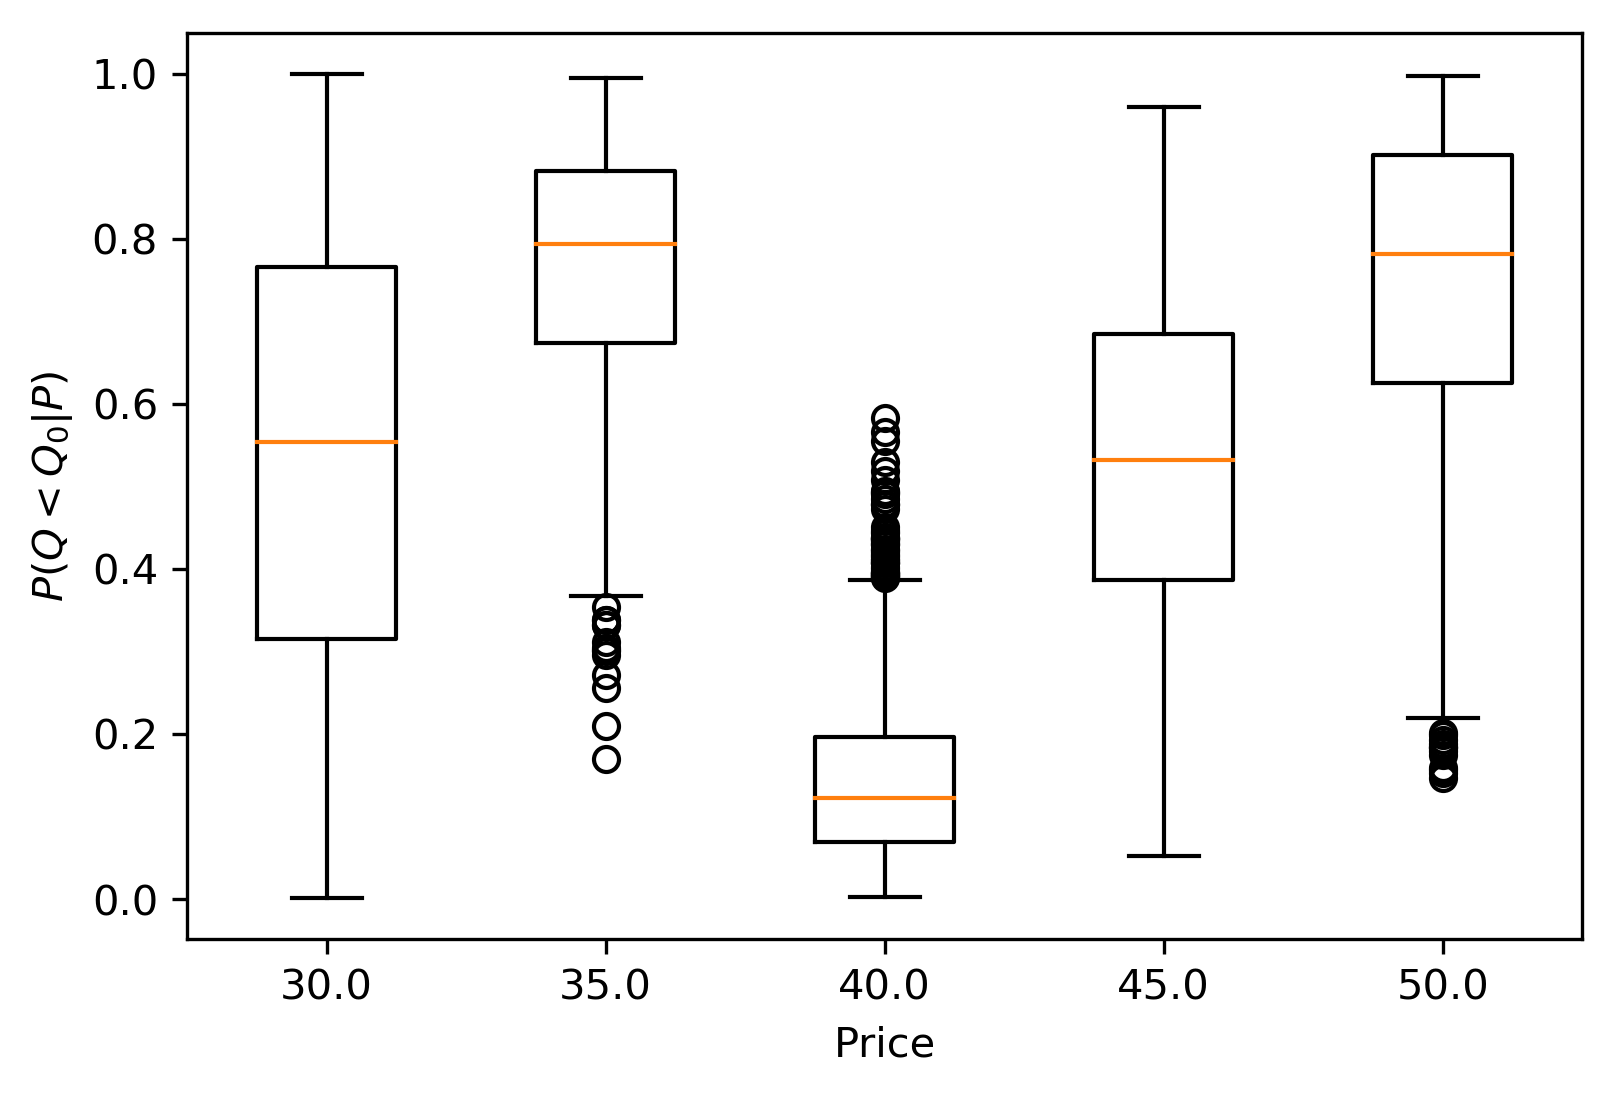

In [17]:
import scipy
plt.boxplot(scipy.stats.poisson.cdf(q0,mu=t['μ0']));
plt.xticks(range(1,6),p0);
plt.xlabel('Price')
plt.ylabel('$P(Q<Q_0 | P)$');

In [34]:
q0

array([53, 45, 25, 26, 25])

In [43]:
import scipy
np.mean(q0  > np.random.poisson(t['μ0']), 0)

array([ 0.5055,  0.7265,  0.1055,  0.451 ,  0.7   ])

In [ ]:
plt.boxplot(scipy.stats.poisson.cdf(q0,mu=t['μ0']));
plt.xticks(range(1,6),p0);
plt.xlabel('Price')
plt.ylabel('$P(Q<Q_0 | P)$');

In [18]:
π = (p - k).reshape(-1,1) * μ

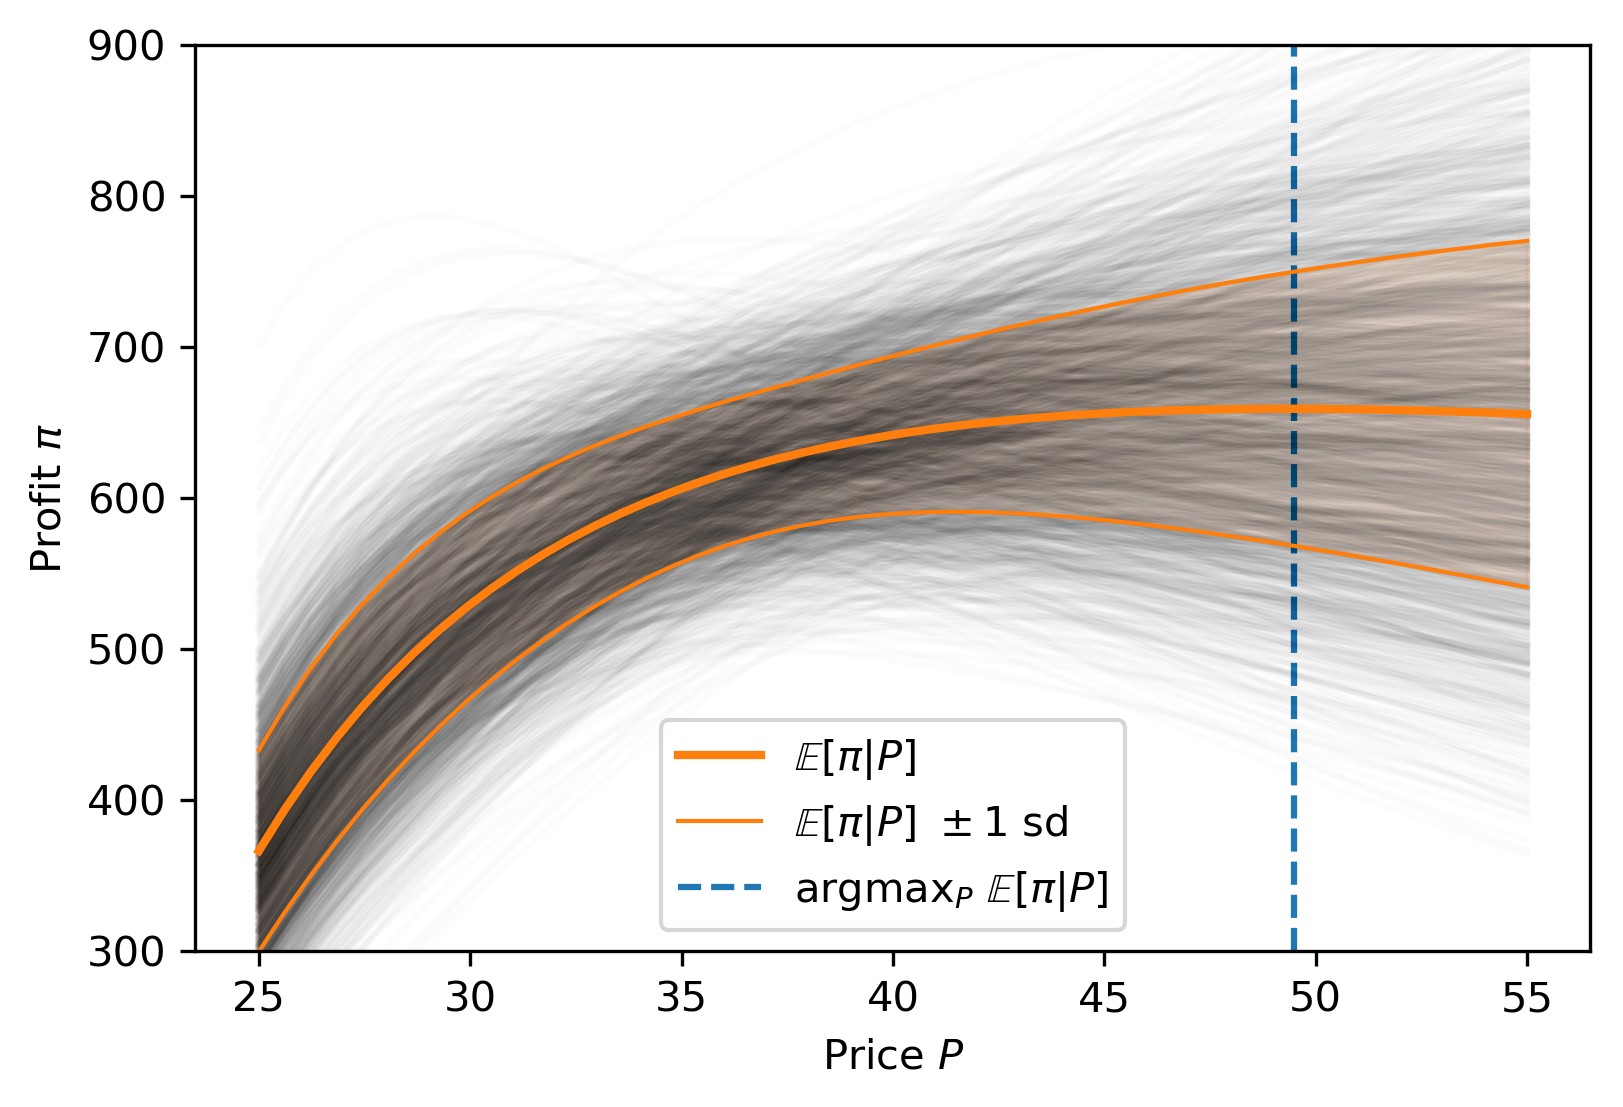

In [19]:
plt.plot(p,π,c='k',alpha=0.01);
plt.plot(p,np.mean(π,1).T,c='C1',lw=2,label="$\mathbb{E}[\pi|P]$");
plt.fill_between(p,(np.mean(π,1)-np.std(π,1)).T,(np.mean(π,1)+np.std(π,1)).T,alpha=0.1,color='C1')
plt.plot(p,(np.mean(π,1)+np.std(π,1)).T,c='C1',lw=1,label="$\mathbb{E}[\pi|P]\ \pm$1 sd");
plt.plot(p,(np.mean(π,1)-np.std(π,1)).T,c='C1',lw=1);
pmax = p[np.argmax(np.mean(π,1))]
plt.vlines(pmax,300,900,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[\pi|P]$")
#plt.plot(p,(p - k) * eq)
plt.ylim(300,900);
plt.xlabel("Price $P$")
plt.ylabel("Profit $\pi$")

plt.legend();

In [20]:
p[np.argmax(np.mean(π,1))]

49.489795918367349

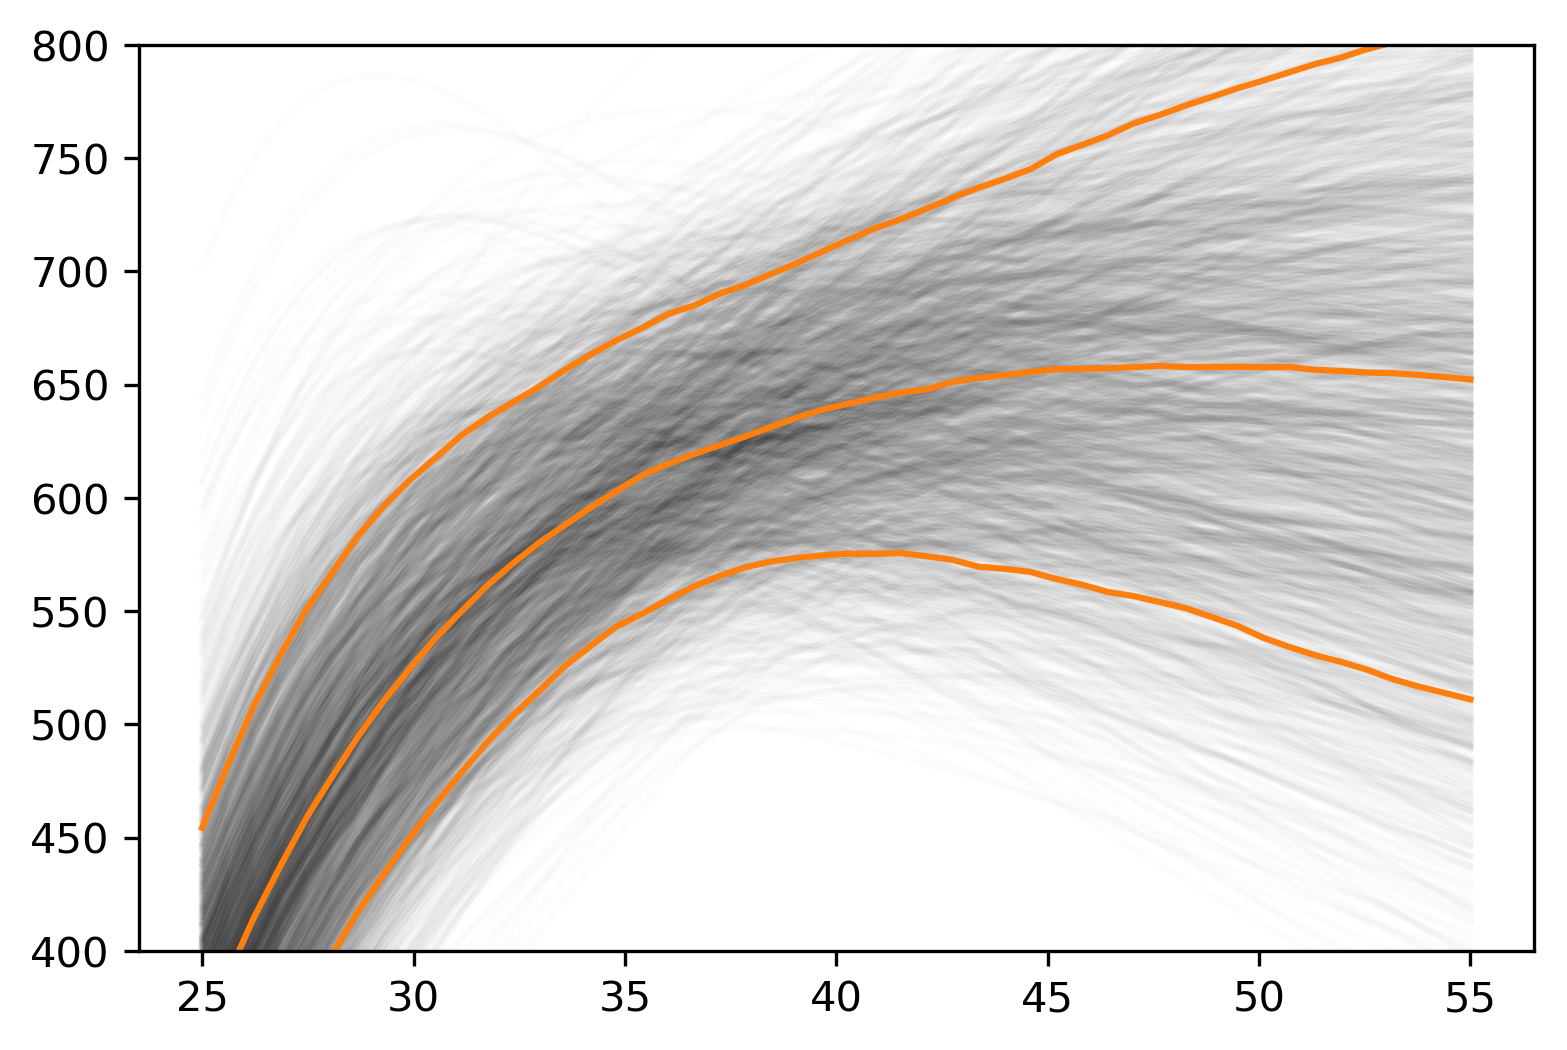

In [21]:
plt.plot(p,π,c='k',alpha=0.01);

plt.plot(p,np.percentile(π,[10,50,90],1).T,c='C1');
#plt.plot(p,(p - k) * eq)
plt.ylim(400,800);

Maximize probability of making at least ...

In [22]:
lo = np.linspace(np.max(np.min(π,1)),800)
m = np.zeros_like(lo)
for (j,πmin) in enumerate(lo):
    m[j] = p[np.argmax(np.mean(π>πmin,1))]

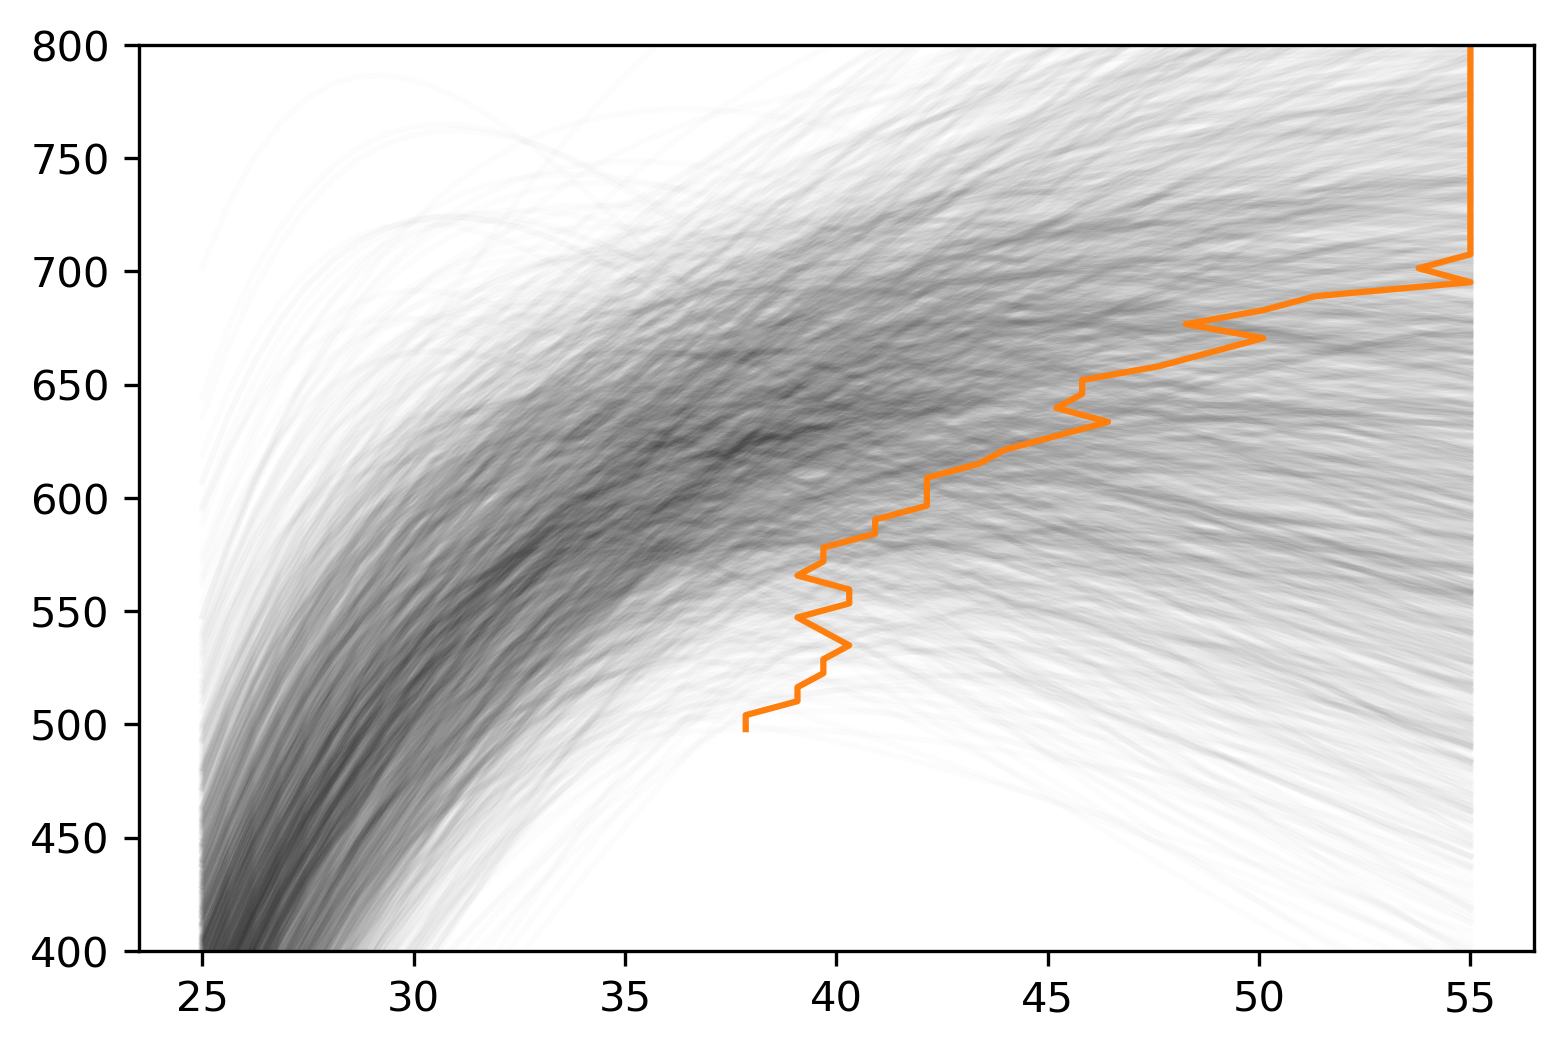

In [23]:
plt.plot(p,π,c='k',alpha=0.01);
plt.plot(m,lo,c='C1')
plt.ylim(400,800);

In [24]:
%config InlineBackend.figure_format = 'png'
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


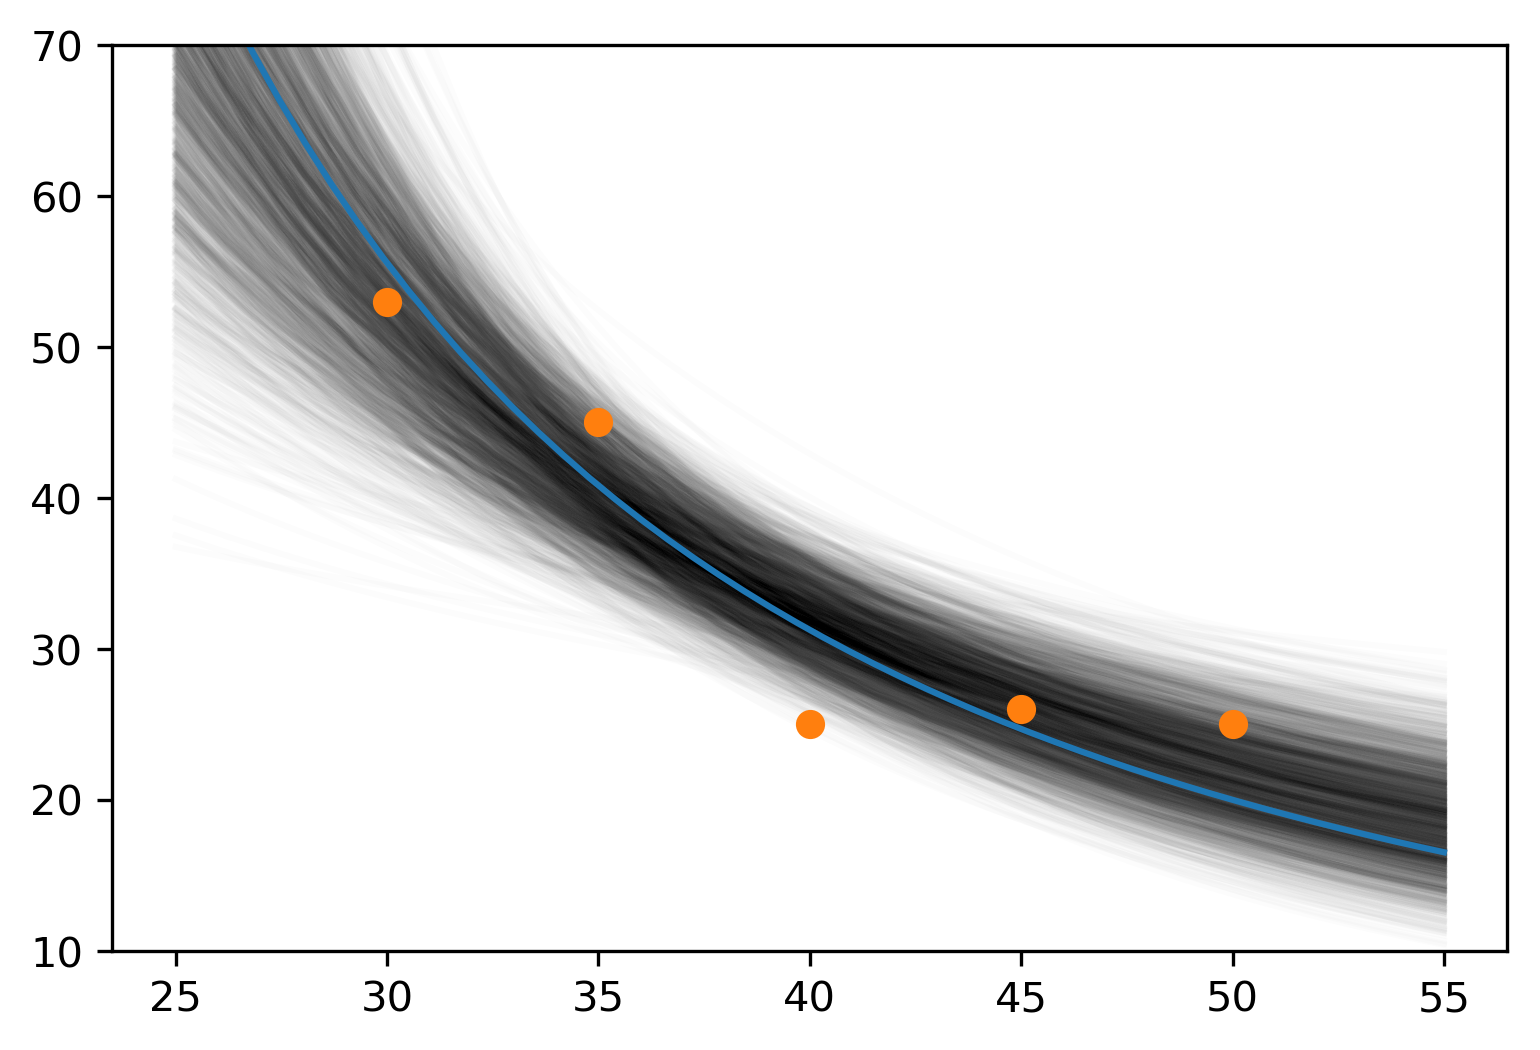

In [25]:
plt.plot(p,μ,c='k',alpha=0.01);
plt.plot(p0,q0,'o',c='C1');
plt.plot(p,eq)
plt.ylim(10,70);

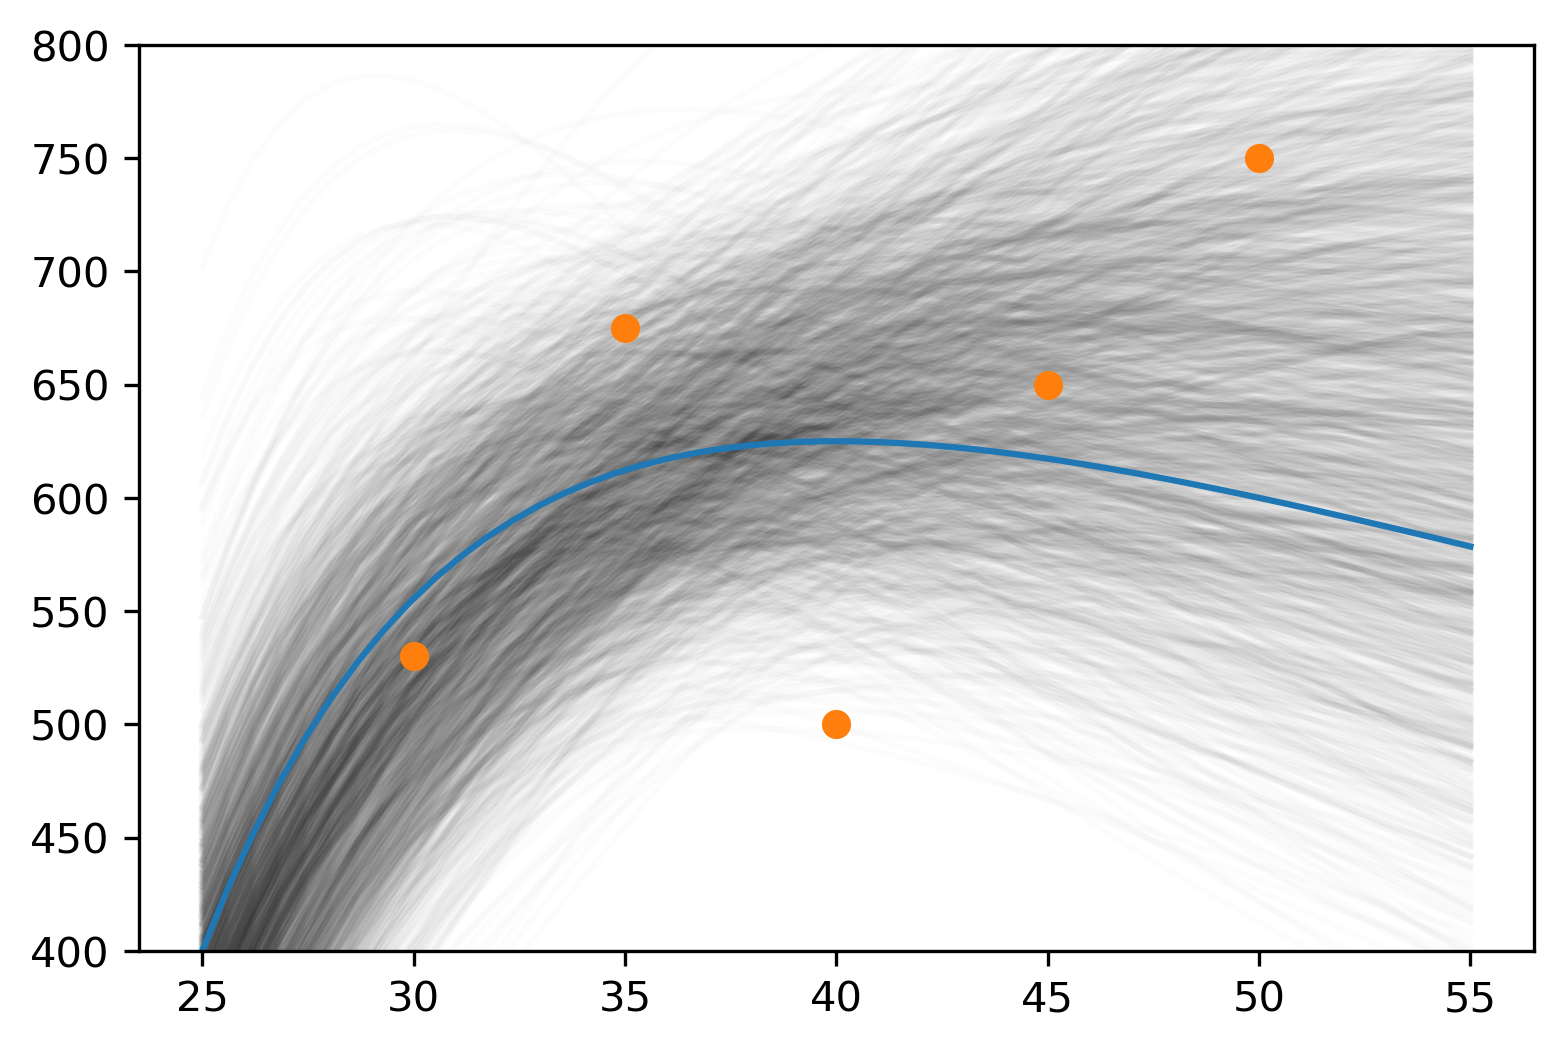

In [26]:
plt.plot(p,π,c='k',alpha=0.01);
#plt.plot(p,np.mean(π,1).T,c='C1',lw=2);
plt.plot(p0,(p0-k)*q0,'o',c='C1',lw=2);
plt.plot(p,(p - k) * eq)
plt.ylim(400,800);